<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [ ]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=55a1618cb4eacb7e119753137355e3120fcb41d41655b38ed7a9266b677451d7
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 133 kB 5.5 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.1

###Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [ ]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [ ]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/df_final.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
0,2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
1,2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2,2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
3,2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
4,2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


In [ ]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
del df['date']

In [ ]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


<Figure size 1800x720 with 0 Axes>

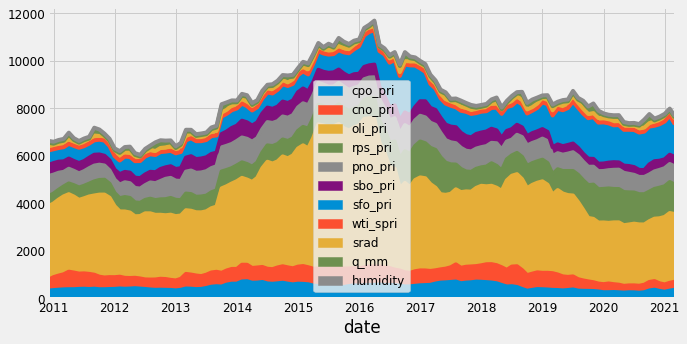

In [ ]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [ ]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [ ]:
print(train.shape)
train.head()

(99, 11)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


###Rescaling Training Data

In [ ]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri',
                   'wti_spri', 'srad', 'q_mm', 'humidity']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.617026,0.366984,0.843364
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.815738,0.007619,0.983088
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.904388,0.073016,0.632580
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,0.717805,0.163492,0.780147
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.789608,0.520317,0.899990


In [ ]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [ ]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.707023,0.548889,0.265874
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.732180,0.017143,0.437683
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.708895,0.444127,0.349664
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.808476,0.181905,0.645800
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.866202,0.436825,0.577974


In [ ]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [ ]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 11) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

###Create Model

In [ ]:
seed=417
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10)

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()

Epoch 1/10
3/3 [==============================] - 1s 195ms/step - loss: 4.5234 - mse: 0.3147 - val_loss: 1.4449 - val_mse: 0.3210
Epoch 2/10
3/3 [==============================] - 0s 23ms/step - loss: 1.4161 - mse: 0.1625 - val_loss: 0.8186 - val_mse: 0.1779
Epoch 3/10
3/3 [==============================] - 0s 21ms/step - loss: 0.7327 - mse: 0.0830 - val_loss: 0.6618 - val_mse: 0.1069
Epoch 4/10
3/3 [==============================] - 0s 23ms/step - loss: 0.6457 - mse: 0.0465 - val_loss: 0.5920 - val_mse: 0.0728
Epoch 5/10
3/3 [==============================] - 0s 21ms/step - loss: 0.6198 - mse: 0.0339 - val_loss: 0.5622 - val_mse: 0.0599
Epoch 6/10
3/3 [==============================] - 0s 34ms/step - loss: 0.6196 - mse: 0.0341 - val_loss: 0.5536 - val_mse: 0.0580
Epoch 7/10
3/3 [==============================] - 0s 29ms/step - loss: 0.6280 - mse: 0.0382 - val_loss: 0.5537 - val_mse: 0.0592
Epoch 8/10
3/3 [==============================] - 0s 36ms/step - loss: 0.6338 - mse: 0.0407 - va

[0.4467690587043762, 0.20507296919822693]

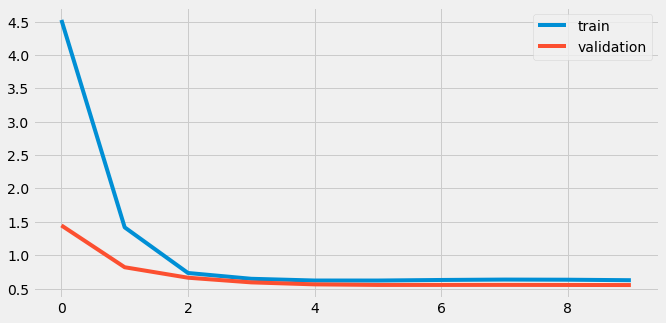

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 23ms/step - loss: 0.4468 - mse: 0.2051


###Tuning CNN with Keras Tuner

In [ ]:
input_shape = (X_test.shape[1], X_test.shape[2])

In [ ]:
from kerastuner import HyperModel
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
################################################################################ACTIVATION
        model.add(
            layers.Dense(
                units=hp.Int('units', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )
################################################################################
        model.add(
            layers.Dense(
                units=hp.Int('units', 16, 64, 4, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
################################################################################### DROPOUT
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )
################################################################################### HIDDEN LAYER
        model.add(
            layers.Dense(
                hp.Float(
                    'num_hidden_layers',
                    #'type": "range',
                     min_value= 1,
                     max_value=10,
                     default=1,
                     step=1)
                    #'value_type': "int"
            )
        )
################################################################################### Neurons_Per_Layer
        model.add(
            layers.Dense(
                hp.Float(
                    'neurons_per_layer',
                    #'type": "range',
                     min_value= 1,
                     max_value=300,
                     default=1,
                     step=16)
                    #'value_type': "int"
            )
        )
##################################################################################  DENSE = 1

        model.add(layers.Dense(1))

################################################################################# LEARNING RATE
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='binary_crossentropy',
            metrics=['mse']
        )
        return model
hypermodel = CNNHyperModel(input_shape=(X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [ ]:
tuner_rs = RandomSearch( hypermodel,
objective='mse',
seed=42,
max_trials=10,
executions_per_trial=2, overwrite=True
)

###Run Random Search

In [ ]:
 tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

INFO:tensorflow:Oracle triggered exit


###Evaluate Random Search

In [ ]:
 best_model = tuner_rs.get_best_models(num_models=1)[0] 
 mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 459ms/step - loss: 0.6199 - mse: 0.2880


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner_rs.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units': 20, 'dense_activation': 'relu', 'dropout': 0.04, 'num_hidden_layers': 9.0, 'neurons_per_layer': 161.0, 'learning_rate': 0.0033137745378583987}


In [ ]:
print('Random search MSE: ', mse_rs)

Random search MSE:  0.2880251705646515


###Build, Run and Evaluate Hyperband Tuner

In [ ]:
tuner_hb = Hyperband( hypermodel,
max_epochs=5, objective='mse', seed=42, executions_per_trial=2, directory='hb')
tuner_hb.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_model = tuner_hb.get_best_models(num_models=1)[0] 
mse_hb = best_model.evaluate(X_test, y_test)[1]

INFO:tensorflow:Reloading Oracle from existing project hb/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from hb/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - 0s 485ms/step - loss: -0.9202 - mse: 0.1913


###Build, Run and Evaluate Bayesian Optimization Tuner

In [ ]:
tuner_bo = BayesianOptimization(hypermodel,
objective='mse', max_trials=10,
seed=42, executions_per_trial=2, directory='bo')
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
best_model = tuner_bo.get_best_models(num_models=1)[0] 
mse_bo = best_model.evaluate(X_test, y_test)[1]

INFO:tensorflow:Reloading Oracle from existing project bo/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from bo/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
1/1 [==============================] - 0s 467ms/step - loss: 1.0322 - mse: 0.4882


In [ ]:
# Get the optimal hyperparameters
best_bo = tuner_bo.get_best_hyperparameters(num_trials = 1)[0]
print(best_bo.values)

{'units': 64, 'dense_activation': 'relu', 'dropout': 0.0, 'num_hidden_layers': 10.0, 'learning_rate': 0.01, 'neurons_per_layer': 1}


In [ ]:
'''
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2]))) #64,32, 16, 8 (best so far)
cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu')) #32, 8,4
#cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(1))
#cnn_model.add(Dropout(0.25))
#Dropout(droprate)
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()
'''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 8)              56        
                                                                 
 dropout_1 (Dropout)         (None, 3, 8)              0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 8)             0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 100       
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                      

The best so far is Hyperband Tuner

In [ ]:
#...updating